In [606]:
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
import snntorch.functional as SF
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from typing import Any
from functools import reduce
from operator import mul

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

from tqdm import tqdm_notebook as tqdm

In [607]:
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [608]:
# class LIFSurrogate(nn.Module):
#     def __init__(self, beta, threshold=1.0, k=25):


#         super(LIFSurrogate, self).__init__()

#         # initialize decay rate beta and threshold
#         self.beta = beta
#         self.threshold = threshold
#         self.surrogate_func = self.LocalZO.apply

#     def init_leaky(self):
#         self.mem = torch.zeros_like(self.mem, device=self.mem.device)
#         return self.mem

#     # the forward function is called each time we call Leaky
#     def forward(self, input_, mem):
#         spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
#         reset = (spk - self.threshold).detach()
#         mem = self.beta * mem + input_ - reset
#         return spk, mem


#     class LocalZO(torch.autograd.Function):
#         @staticmethod
#         def forward(ctx, input):
#             delta = 0.05
#             out = (input > 0).float()
#             L = torch.tensor([delta])
#             ctx.save_for_backward(input, L)
#             return out

#         @staticmethod
#         def backward(ctx, grad_output):
#             (input, others) = ctx.saved_tensors
#             delta = others[0].item()
#             grad_input = grad_output.clone()
            
#             sample_size=5
#             abs_z = torch.abs(torch.randn((sample_size,)+input.size(), device=torch.device('cuda'), dtype=torch.float))
#             t=torch.abs(input[None,:,:])< abs_z*delta
#             grad_input=grad_input*torch.mean(t*abs_z, dim=0)/(2*delta)

#             return grad_input, None    

In [609]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95


# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # self.dummy_param = nn.Parameter(torch.empty(0))
        spike_grad = self.local_zo(delta=0.6, q=1)
        # spike_grad = surrogate.fast_sigmoid(slope=25)
        
        
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        # return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        return torch.stack(spk2_rec), torch.stack(mem2_rec)
    
    def get_params(self):
        params = []
        for name, module in self.named_modules():
            if len(module._parameters) != 0:
                params.append(module._parameters['weight'].data.view(-1))
                try:
                    params.append(module._parameters['bias'].data.view(-1))
                except:
                    pass
        return torch.cat(params)
    

    def get_grad(self):
        grads = []
        for name, module in self.named_modules():
            if len(module._parameters) != 0:
                grads.append(module._parameters['weight'].grad.view(-1))
                try:
                    grads.append(module._parameters['bias'].grad.view(-1))
                except:
                    pass
        return torch.cat(grads)     


    def set_params(self, flat_params):
        # Restore original shapes
        offset = 0
        for module in self.modules():
            if len(module._parameters) != 0:
                weight_shape = module._parameters['weight'].size()
                weight_flat_size = reduce(mul, weight_shape, 1)
                module._parameters['weight'].data = flat_params[
                                               offset:offset + weight_flat_size].view(*weight_shape)
                try:
                    bias_shape = module._parameters['bias'].size()
                    bias_flat_size = reduce(mul, bias_shape, 1)
                    module._parameters['bias'].data = flat_params[
                                                 offset + weight_flat_size:offset + weight_flat_size + bias_flat_size].view(
                        *bias_shape)
                except:
                    bias_flat_size = 0
                offset += weight_flat_size + bias_flat_size

    
    def get_params_size(self):
        return self.get_params().size(0)
    

    def local_zo(self, delta=0.05, q=1):
        
        def inner(input_):
            return self.LocalZO.apply(input_, delta, q)
        return inner
    

    class LocalZO(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input_, delta=0.05, q=1):
            grad = torch.zeros_like(input_).to(device)
            for _ in range(q):
                z = torch.randn_like(input_)
                grad += (torch.abs(input_) < delta * torch.abs(z)) * torch.abs(z) / (2 * delta)
            torch.div(grad, q)

            ctx.save_for_backward(grad)
            out = (input_ > 0).float()
            
            return out
        

        @staticmethod
        def backward(ctx, grad_output):
            (grad,) = ctx.saved_tensors
            grad_input = grad_output.clone()

            return grad * grad_input, None, None
# Load the network onto CUDA if available
net = Net().to(device)



In [610]:
class NNOptimizer(nn.Module):
    def __init__(self, model, args):
        super(NNOptimizer, self).__init__()
        self.meta_model = model

    def reset_state(self):
        raise NotImplementedError

    def meta_update(self, *input):
        raise NotImplementedError

    def GradientEstimate(self, model, data, target, loss, direction, mu=0.000001):
        model_params = model.get_params()
        updated_model_params = model_params + mu * direction

        f_x1, _ = model(data)
        loss1 = loss(f_x1, target)

        model.set_params(updated_model_params)
        f_x2, _ = model(data)
        loss2 = loss(f_x2, target)

        grads = (loss2 - loss1) / mu
        if not self.training:
            grads.detach_()
        # grads.detach_()
        model.set_params(model_params)
        return grads

    def save(self, epoch, outdir, best=False):
        if not best:
            filepath = os.path.join(outdir, "ckpt_{}".format(epoch))
            print("Saving model state at epoch {} to {}".format(epoch, filepath))
        else:
            filepath = os.path.join(outdir, "ckpt_best")
            print("Saving model state at epoch {} to {}".format(epoch, filepath))
        torch.save({'epoch': epoch,
                    'state_dict': self.state_dict()}, filepath)

    def load(self, ckpt_path):
        assert os.path.isfile(ckpt_path)
        ckpt_dict = torch.load(ckpt_path, map_location='cpu')
        self.load_state_dict(ckpt_dict['state_dict'])
        # print(ckpt_dict['state_dict'])
        epoch = ckpt_dict['epoch']
        print("Loaded checkpoint '{}' from epoch {}".format(ckpt_path, epoch))

class AdamZOOptimizer(NNOptimizer):
    def __init__(self, model, args, lr=25, beta_1=0.9, beta_2=0.996):
        super(AdamZOOptimizer, self).__init__(model, args)
        # self.q = args.grad_est_q
        self.q = 1
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def reset_state(self, keep_states=False, model=None, use_cuda=False, gpu_num=0):
        self.first_moment = torch.zeros_like(model.get_params())
        self.second_moment = torch.zeros_like(model.get_params())
        self.step = 0

    def meta_update(self, model, data, target, loss, grad=None):
        f_x, _ = model(data)
        loss_val = loss(f_x, target)

        self.step += 1

        # flat_grads = torch.zeros_like(model.get_params())
        # for _ in range(self.q):
        #     u = torch.randn_like(model.get_params())  # sampled query direction
        #     flat_grads += self.GradientEstimate(model, data, target, loss, u, mu=0.6) * u
        # flat_grads /= self.q
        flat_grads = grad

        self.first_moment = self.beta_1 * self.first_moment + (1 - self.beta_1) * flat_grads
        debiased_first_moment = self.first_moment / (1 - self.beta_1 ** self.step)
        self.second_moment = self.beta_2 * self.second_moment + (1 - self.beta_2) * (flat_grads ** 2)
        debiased_second_moment = self.second_moment / (1 - self.beta_2 ** self.step)
        flat_grads = debiased_first_moment / (debiased_second_moment.sqrt() + 1e-8)

        lr = self.lr / model.get_params_size()
        flat_params = model.get_params()
        delta = - flat_grads * lr
        flat_params = flat_params + delta
        model.set_params(flat_params)

        return None, loss_val, f_x
    

    def gd_update(self, model, data, target, grad, lr):
        model.set_params(model.get_params() - lr * grad)

In [611]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [612]:
# loss = nn.CrossEntropyLoss()
loss = SF.ce_rate_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
# optimizer = torch.optim.SGD(net.parameters(), lr=5e-4)


opt = AdamZOOptimizer(net, None, lr=5e-4)

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# def GradientEstimate(model, data, target, direction, mu=0.000001):
#     model_params = model.get_params()
#     updated_model_params = model_params + mu * direction

#     f_x1, _ = model(data)
#     loss1 = loss(f_x1, target)

#     model.set_params(updated_model_params)
#     f_x2, _ = model(data)
#     loss2 = loss(f_x2, target)

#     grads = (loss2 - loss1) / mu
#     # if not self.training:
#         # grads.detach_()
#     # grads.detach_()
#     model.set_params(model_params)
#     return grads

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    opt.reset_state(model=net)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        loss_val = loss(spk_rec, targets)
        optimizer.zero_grad()
        loss_val.backward()
        # opt.meta_update(net, data.view(batch_size, -1), targets, loss, net.get_grad())
        opt.gd_update(net, data.view(batch_size, -1), targets, net.get_grad(), 5e-3)
        # optimizer.step()

        # net.set_params(net.get_params())

        # print(net.get_params().shape)
        # print(net.get_grad().shape)
        # q = 1
        # flat_grads = torch.zeros_like(net.get_params())
        # for _ in range(q):
        #     z = torch.randn_like(net.get_params())
        #     flat_grads += GradientEstimate(net, data.view(batch_size, -1), targets, z, mu=1e-19) * z
        # flat_grads /= q

        # lr = 25 / net.get_params_size()
        # flat_params = net.get_params()
        # delta = - flat_grads * lr
        # flat_params = flat_params + delta
        # net.set_params(flat_params)
        # _, loss_val, spk_rec = opt.meta_update(net, data.view(batch_size, -1), targets, loss)

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set  
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            # test_loss = torch.zeros((1), dtype=dtype, device=device)
            # for step in range(num_steps):
                # test_loss += loss(test_mem[step], test_targets)
            test_loss = loss(test_spk, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 2.31
Test Set Loss: 2.31
Train set accuracy for a single minibatch: 16.41%
Test set accuracy for a single minibatch: 10.16%


Epoch 0, Iteration 50
Train Set Loss: 1.87
Test Set Loss: 1.87
Train set accuracy for a single minibatch: 80.47%
Test set accuracy for a single minibatch: 78.91%


Epoch 0, Iteration 100
Train Set Loss: 1.75
Test Set Loss: 1.77
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 76.56%


Epoch 0, Iteration 150
Train Set Loss: 1.67
Test Set Loss: 1.69
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 200
Train Set Loss: 1.67
Test Set Loss: 1.67
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 250
Train Set Loss: 1.65
Test Set Loss: 1.69
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 85.16%


Epoch 0, Iter

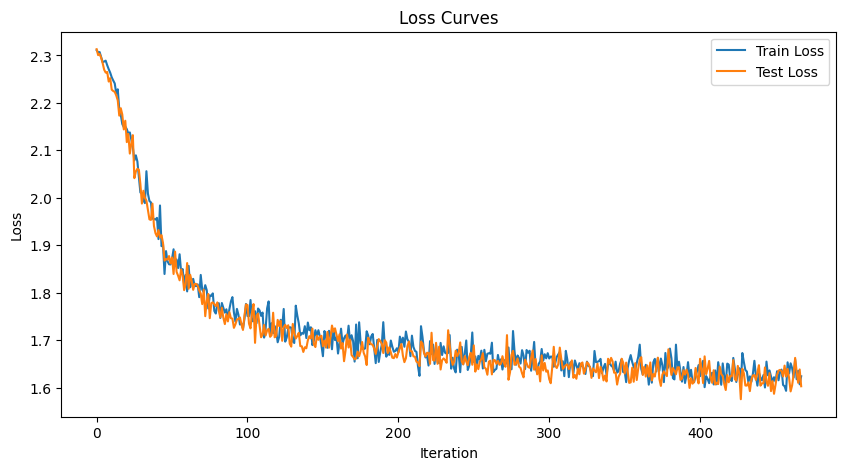

In [613]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()